In [2]:
import scipy
print(scipy.__version__)

1.16.1


In [4]:
path2 = "wind_resource_pipeline.py"  # 같은 폴더에 저장
with open(path2, "w", encoding="utf-8") as f:
    f.write(script2)


In [6]:
path2 = "wind_resource_pipeline.py"  # 현재 폴더에 저장
with open(path2, "w", encoding="utf-8") as f:
    f.write(script2)


In [7]:
!ls -l wind_resource_pipeline.py


-rw-r--r--@ 1 sunny  staff  8383 Aug 13 11:51 wind_resource_pipeline.py


In [10]:
# 현재 폴더에 저장
path = "asos_weibull_example.py"
with open(path, "w", encoding="utf-8") as f:
    f.write(script)


[INFO] 요청: http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList
[INFO] 컬럼: ['tm', 'rnum', 'stnId', 'stnNm', 'ta', 'taQcflg', 'rn', 'rnQcflg', 'ws', 'wsQcflg', 'wd', 'wdQcflg', 'hm', 'hmQcflg', 'pv', 'td', 'pa', 'paQcflg', 'ps', 'psQcflg', 'ss', 'ssQcflg', 'icsr', 'dsnw', 'hr3Fhsc', 'dc10Tca', 'dc10LmcsCa', 'clfmAbbrCd', 'lcsCh', 'vs', 'gndSttCd', 'dmstMtphNo', 'ts', 'tsQcflg', 'm005Te', 'm01Te', 'm02Te', 'm03Te']
[INFO] CSV 저장: asos_108_20240101_20241231.csv (rows=10)
[WARN] 샘플 수가 적습니다(100 미만). 결과가 불안정할 수 있습니다.
[RESULT] Weibull params: shape k=3.0615, scale c=1.7672
[INFO] 그래프 저장: asos_108_20240101_20241231_weibull.png
[INFO] 기간 평균 풍속: 1.580 m/s


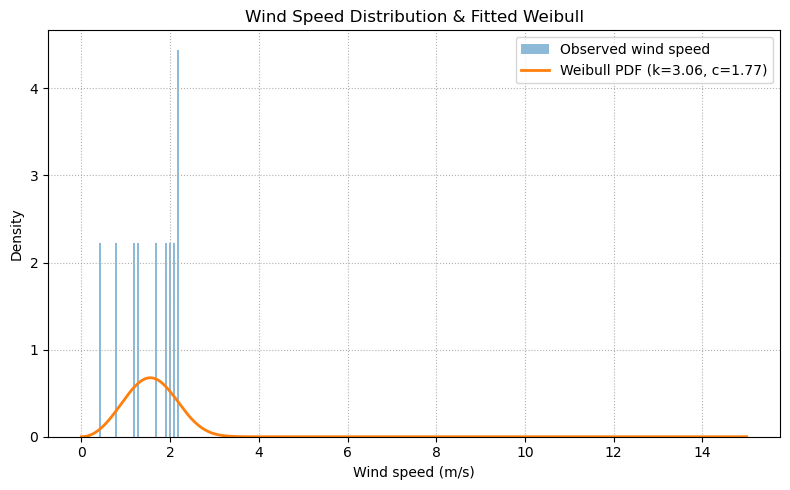

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
ASOS(종관기상관측) 풍속 데이터 수집 + Weibull 피팅 예제
- 출처: 공공데이터포털(data.go.kr) 기상청 ASOS 시간자료 API :XxGq5RBwYIBVOaYCTXMKbOYPAi1x/yQOZYXIUh2SjLkQMN57O2caIr90kEAh7arbA5KjZpGd5xI1WEfuU1X0aw==
- 사용 전: 아래 CONFIG에서 API_KEY, STATION_ID, 기간을 설정하세요.
- 의존성: requests, pandas, numpy, scipy, matplotlib
    pip install requests pandas numpy scipy matplotlib
"""

import sys
import pandas as pd
import numpy as np
import requests
from scipy.stats import weibull_min
import matplotlib.pyplot as plt


# -----------------------
# CONFIG
# -----------------------
API_KEY = "XxGq5RBwYIBVOaYCTXMKbOYPAi1x/yQOZYXIUh2SjLkQMN57O2caIr90kEAh7arbA5KjZpGd5xI1WEfuU1X0aw=="   # 공공데이터포털 발급 키 (URL 인코딩되지 않은 일반 키)
STATION_ID = "108"  # 서울=108, 부산=159 등
START_DATE = "20240101"  # YYYYMMDD
START_HH   = "00"        # 00~23
END_DATE   = "20241231"
END_HH     = "23"


def fetch_asos_hourly(api_key: str, stn_id: str, start_dt: str, start_hh: str, end_dt: str, end_hh: str) -> pd.DataFrame:
    """
    ASOS 시간자료 API 호출
    """
    base_url = "http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList"
    params = {
        "serviceKey": api_key,
        "dataType": "JSON",
        "dataCd": "ASOS",
        "dateCd": "HR",
        "startDt": start_dt,
        "startHh": start_hh,
        "endDt": end_dt,
        "endHh": end_hh,
        "stnIds": stn_id,
    }
    print("[INFO] 요청:", base_url)
    r = requests.get(base_url, params=params, timeout=60)
    r.raise_for_status()
    j = r.json()
    if j.get("response", {}).get("header", {}).get("resultCode") != "00":
        print("[WARN] API header:", j.get("response", {}).get("header"))
    items = j.get("response", {}).get("body", {}).get("items", {}).get("item", [])
    if not items:
        print("[ERROR] 수신된 데이터가 없습니다. 파라미터/기간/관측소 코드를 확인하세요.")
        return pd.DataFrame()

    df = pd.DataFrame(items)
    print("[INFO] 컬럼:", list(df.columns))

    if "tm" in df.columns:
        df["tm"] = pd.to_datetime(df["tm"], errors="coerce")
        df = df.sort_values("tm").reset_index(drop=True)

    for col in ["ws", "wd", "ta", "hm"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df


def fit_weibull(ws: pd.Series):
    """
    풍속 데이터로 Weibull 분포(k, c) 피팅
    """
    ws = ws.dropna()
    ws = ws[ws >= 0]
    if len(ws) < 100:
        print("[WARN] 샘플 수가 적습니다(100 미만). 결과가 불안정할 수 있습니다.")
    k, loc, c = weibull_min.fit(ws.values, floc=0)
    return k, c


def plot_hist_with_weibull(ws: pd.Series, k: float, c: float, out_png: str):
    """
    히스토그램 + Weibull PDF 시각화
    """
    ws = ws.dropna()
    ws = ws[ws >= 0]
    if ws.empty:
        print("[WARN] 그릴 데이터가 없습니다.")
        return

    plt.figure(figsize=(8, 5))
    plt.hist(ws.values, bins=40, density=True, alpha=0.5, label="Observed wind speed")

    x = np.linspace(0, max(ws.max(), 15), 400)
    pdf = weibull_min.pdf(x, k, scale=c)

    plt.plot(x, pdf, linewidth=2, label=f"Weibull PDF (k={k:.2f}, c={c:.2f})")
    plt.title("Wind Speed Distribution & Fitted Weibull")
    plt.xlabel("Wind speed (m/s)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    print(f"[INFO] 그래프 저장: {out_png}")


def main():
    df = fetch_asos_hourly(API_KEY, STATION_ID, START_DATE, START_HH, END_DATE, END_HH)
    if df.empty:
        sys.exit(1)

    out_csv = f"asos_{STATION_ID}_{START_DATE}_{END_DATE}.csv"
    df.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print(f"[INFO] CSV 저장: {out_csv} (rows={len(df)})")

    if "ws" not in df.columns:
        print("[ERROR] 'ws'(풍속) 컬럼이 없습니다.")
        print(df.head())
        sys.exit(1)

    k, c = fit_weibull(df["ws"])
    print(f"[RESULT] Weibull params: shape k={k:.4f}, scale c={c:.4f}")

    out_png = f"asos_{STATION_ID}_{START_DATE}_{END_DATE}_weibull.png"
    plot_hist_with_weibull(df["ws"], k, c, out_png)

    mean_ws = df["ws"].dropna().mean()
    print(f"[INFO] 기간 평균 풍속: {mean_ws:.3f} m/s")


if __name__ == "__main__":
    main()
